In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [4]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['time'].dt.month

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [5]:
lags = [24, 25, 26, 48, 49, 50, 72, 96, 120, 144, 168]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'avg_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().mean()
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag)
    

df.reset_index(inplace=True)

df.dropna(inplace=True)


In [6]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [7]:
target = 'consumption'

df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

excluded_features = ['time', 'temperature', 'consumption', 'original_location']
features_0_10 = [col for col in df.columns if col not in excluded_features]
features_11_24 = [col for col in df.columns if col not in excluded_features + ['consumption_t-24h', 'avg_load_t-24h']]


df_0_10.dropna(subset=features_0_10 + [target], inplace=True)
df_11_24.dropna(subset=features_11_24 + [target], inplace=True)

last_date = df['time'].max().date()
test_start_date = last_date - timedelta(days=29)

train_0_10 = df_0_10[df_0_10['time'].dt.date < test_start_date]
test_0_10 = df_0_10[df_0_10['time'].dt.date >= test_start_date]

train_11_24 = df_11_24[df_11_24['time'].dt.date < test_start_date]
test_11_24 = df_11_24[df_11_24['time'].dt.date >= test_start_date]

model_0_10 = RandomForestRegressor(n_estimators=100, random_state=42)
model_0_10.fit(train_0_10[features_0_10], train_0_10[target])

model_11_24 = RandomForestRegressor(n_estimators=100, random_state=42)
model_11_24.fit(train_11_24[features_11_24], train_11_24[target])

pred_0_10 = model_0_10.predict(test_0_10[features_0_10])
mse_0_10 = mean_squared_error(test_0_10[target], pred_0_10)

pred_11_24 = model_11_24.predict(test_11_24[features_11_24])
mse_11_24 = mean_squared_error(test_11_24[target], pred_11_24)

print(f'MSE for 0-10: {mse_0_10}')
print(f'MSE for 11-24: {mse_11_24}')


MSE for 0-10: 0.3453819010362544
MSE for 11-24: 0.23738067023704865


        time original_location  consumption  prediction
0 2023-03-04            bergen     3.044938    2.989187
1 2023-03-04       helsingfors     6.373000    6.366061
2 2023-03-04              oslo    10.704361   11.201179
3 2023-03-04         stavanger     5.085620    5.306201
4 2023-03-04            tromsø     1.954974    1.739481


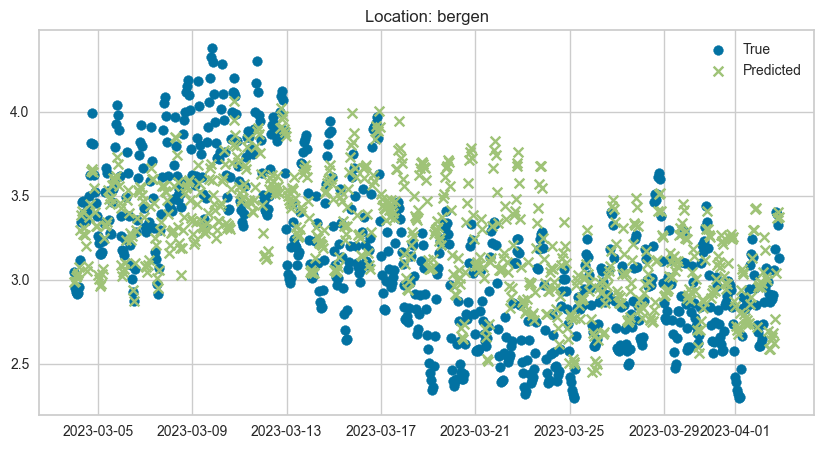

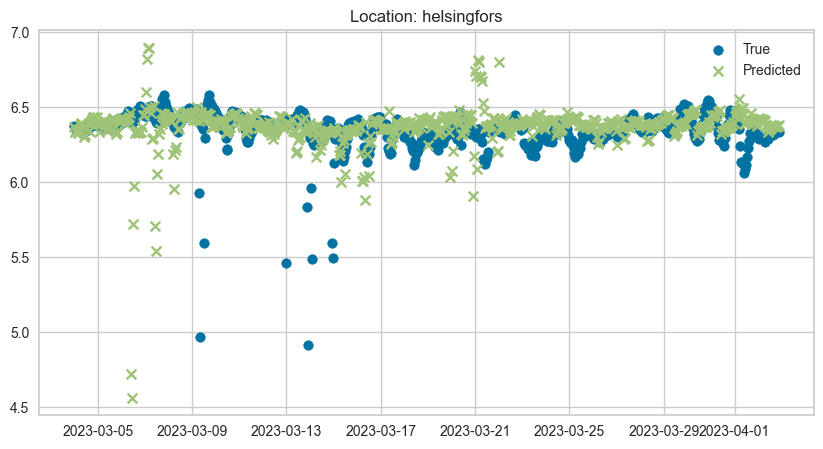

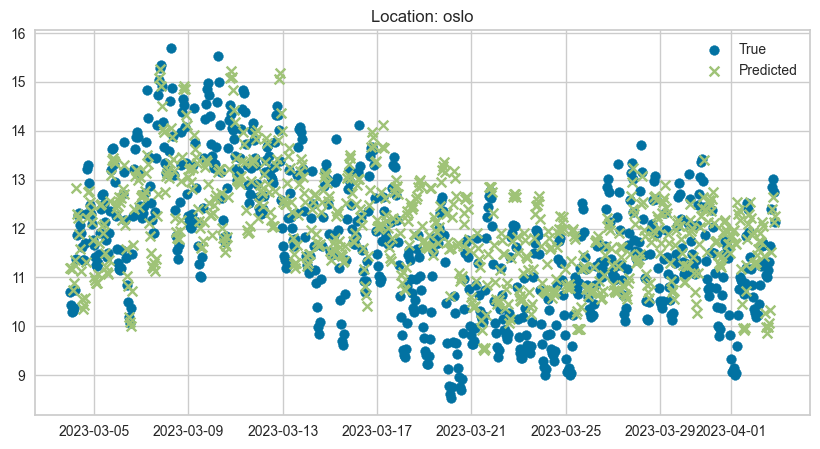

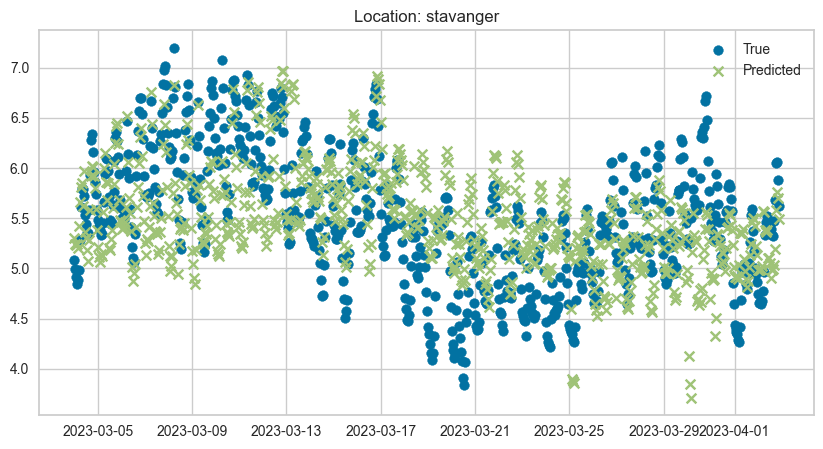

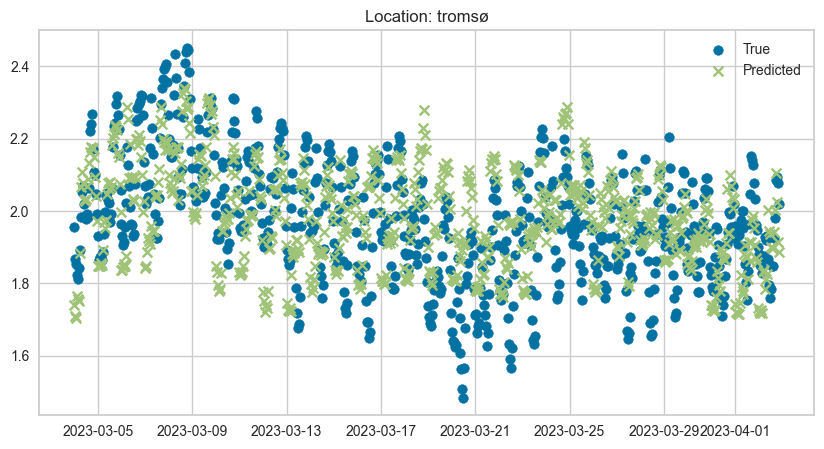

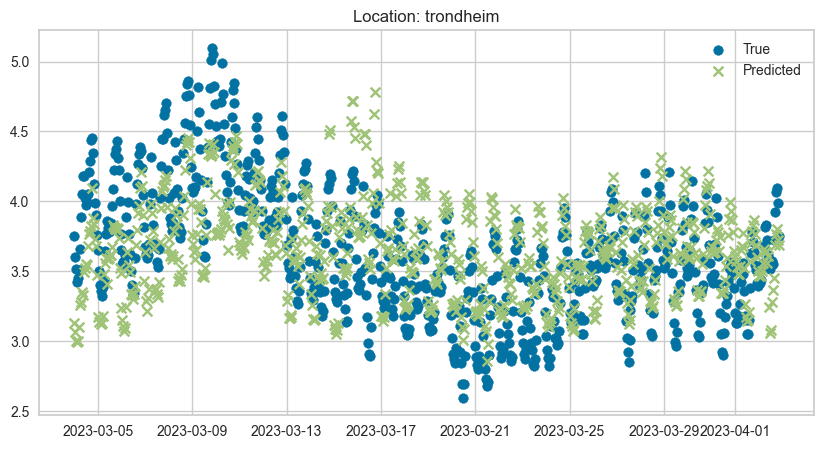

In [8]:


predictions_0_10 = model_0_10.predict(test_0_10[features_0_10])
results_0_10 = test_0_10[['time', 'original_location', target]].copy()
results_0_10['prediction'] = predictions_0_10

predictions_11_24 = model_11_24.predict(test_11_24[features_11_24])
results_11_24 = test_11_24[['time', 'original_location', target]].copy()
results_11_24['prediction'] = predictions_11_24

combined_results = pd.concat([results_0_10, results_11_24])

combined_results = combined_results.sort_values(by='time')

combined_results.reset_index(drop=True, inplace=True)

print(combined_results.head())


locations = combined_results['original_location'].unique()
for location in locations:
    location_data = combined_results[combined_results['original_location'] == location]
    plt.figure(figsize=(10,5))
    plt.scatter(location_data['time'], location_data[target], label='True', marker='o')
    plt.scatter(location_data['time'], location_data['prediction'], label='Predicted', marker='x')
    plt.title(f'Location: {location}')
    plt.legend()
    plt.show()


In [23]:
import pandas as pd
import pycaret.regression as pyr
# Assuming df is already loaded
df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

train_0_10 = df_0_10[df_0_10['time'].dt.date < test_start_date]
test_0_10 = df_0_10[df_0_10['time'].dt.date >= test_start_date]

train_11_24 = df_11_24[df_11_24['time'].dt.date < test_start_date]
test_11_24 = df_11_24[df_11_24['time'].dt.date >= test_start_date]

excluded_features = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 
                           'temperature', 
                           'original_location', 
                           'consumption_t-24h', 
                           'avg_load_t-24h',
                           'consumption_t-25h', 
                           'avg_load_t-25h',
                           'consumption_t-26h',
                           'avg_load_t-26h',
                           ]


pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features, test_data=test_0_10, session_id=42)
best_model_0_10 = pyr.compare_models(sort='mae')


pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, test_data=test_11_24, session_id=42)
best_model_11_24 = pyr.compare_models(sort='mae')


predictions_0_10 = pyr.predict_model(best_model_0_10, data=test_0_10)
predictions_11_24 = pyr.predict_model(best_model_11_24, data=test_11_24)

combined_predictions = pd.concat([predictions_0_10, predictions_11_24]).sort_values(by='time')



,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(19900, 47)"
4,Transformed data shape,"(19900, 44)"
5,Transformed train set shape,"(18100, 44)"
6,Transformed test set shape,"(1800, 44)"
7,Ignore features,3
8,Numeric features,43
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:13:09
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.3234,0.3004,0.4921,0.8945,0.1051,0.1385,0.2420
omp,Orthogonal Matching Pursuit,0.3335,0.3255,0.5129,0.8997,0.1087,0.1462,0.0390
en,Elastic Net,0.3862,0.4413,0.5839,0.8612,0.1169,0.1648,0.0770
lr,Linear Regression,0.4645,0.5358,0.6637,0.3529,0.1610,0.2506,0.4460
lasso,Lasso Regression,0.4718,0.5506,0.6674,0.7983,0.1414,0.2223,0.3350
llar,Lasso Least Angle Regression,0.4718,0.5506,0.6674,0.7983,0.1414,0.2223,0.0380
lar,Least Angle Regression,11091168.1082,1302500478297462.2500,13960643.0428,-120073529467473.5312,9.0513,4292535.7725,0.0420


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:16:21
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2756,0.2585,0.4466,0.9369,0.0789,0.0874,3.4720
lightgbm,Light Gradient Boosting Machine,0.2767,0.2436,0.4373,0.9425,0.0766,0.0842,1.3680
gbr,Gradient Boosting Regressor,0.2823,0.2617,0.4546,0.9373,0.0785,0.0860,3.3850
huber,Huber Regressor,0.3017,0.3280,0.4937,0.9339,0.0822,0.0910,0.4570
rf,Random Forest Regressor,0.3021,0.3122,0.4886,0.9329,0.0839,0.0924,10.4790
ridge,Ridge Regression,0.3305,0.3038,0.4999,0.9088,0.1004,0.1245,0.0340
br,Bayesian Ridge,0.3342,0.3069,0.5052,0.9065,0.1013,0.1259,0.0730
omp,Orthogonal Matching Pursuit,0.3480,0.3421,0.5291,0.9113,0.1045,0.1319,0.0320
en,Elastic Net,0.3777,0.4264,0.5738,0.8950,0.1069,0.1395,0.1040
dt,Decision Tree Regressor,0.3942,0.5301,0.6412,0.9012,0.1090,0.1212,0.2150


ValueError: Number of features of the model must match the input. Model n_features_ is 43 and input n_features is 40

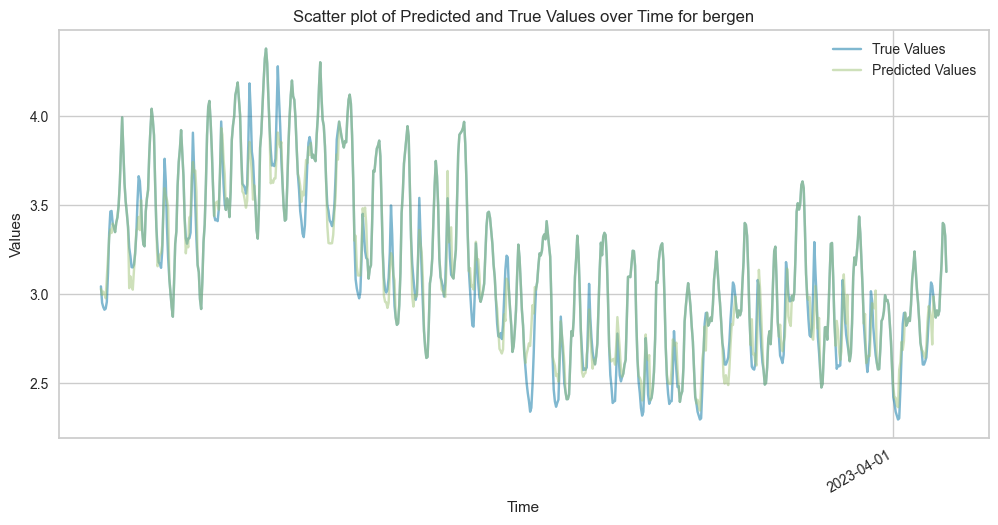

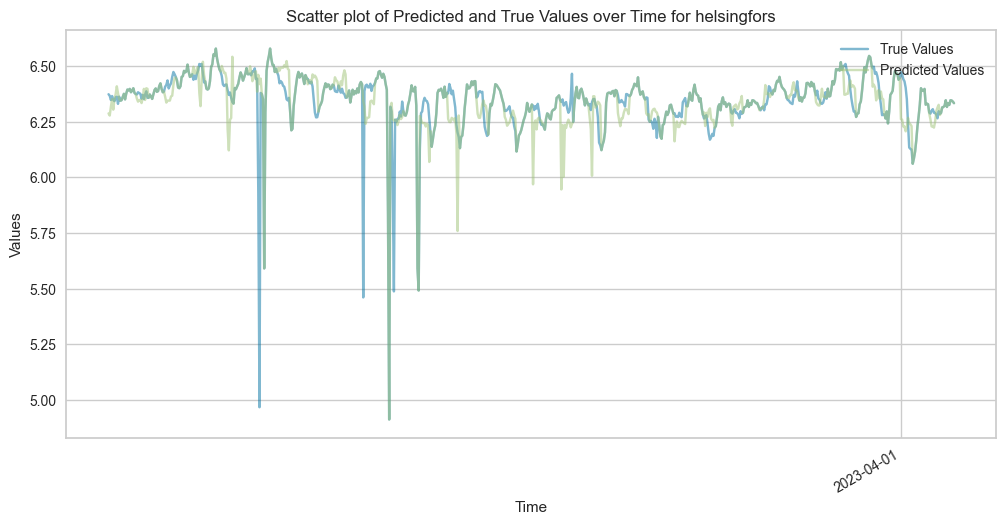

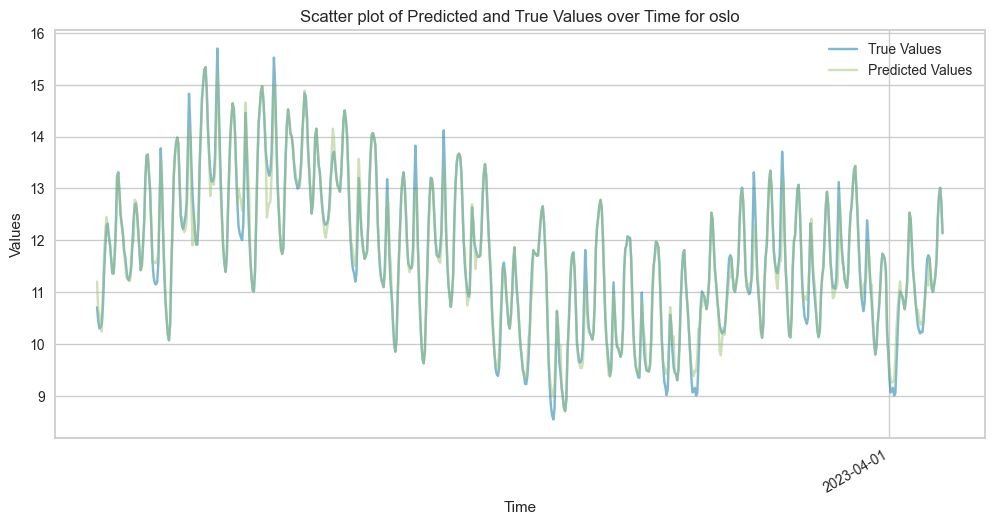

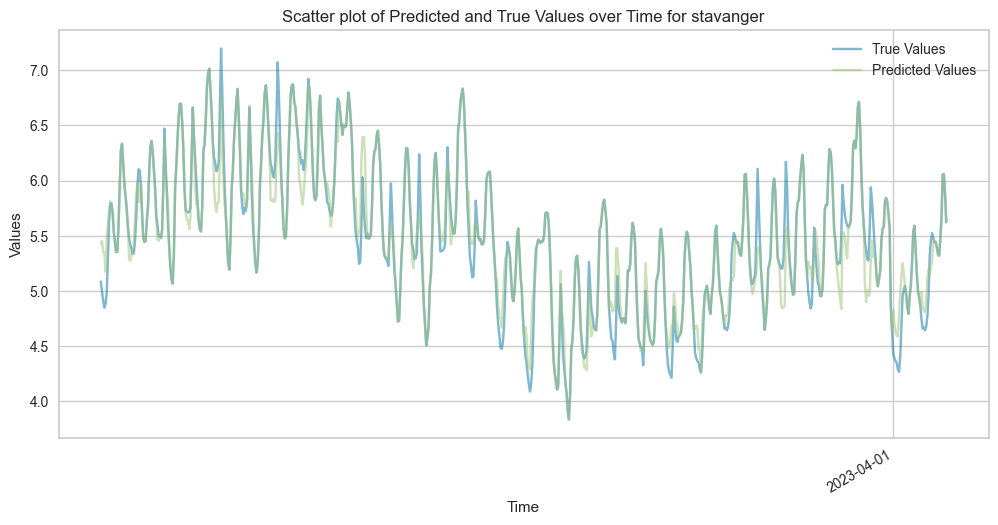

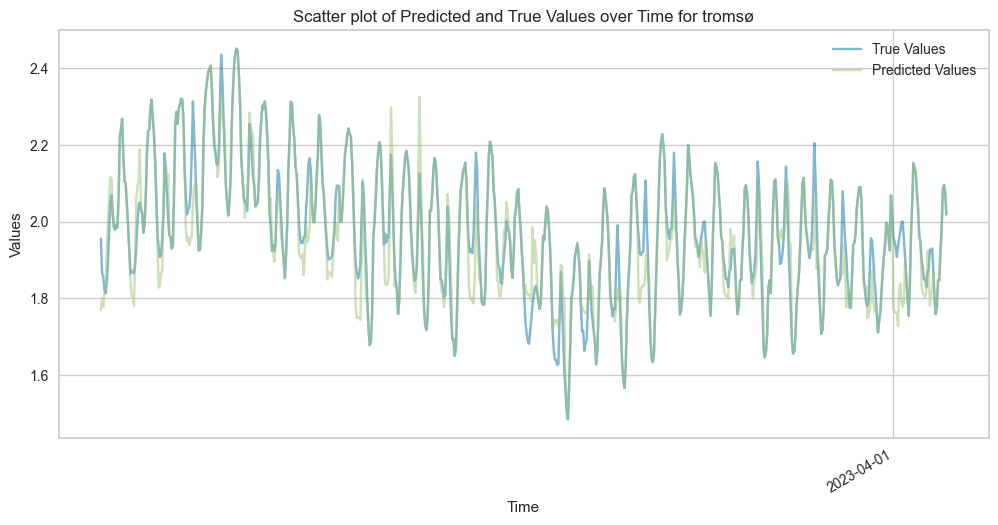

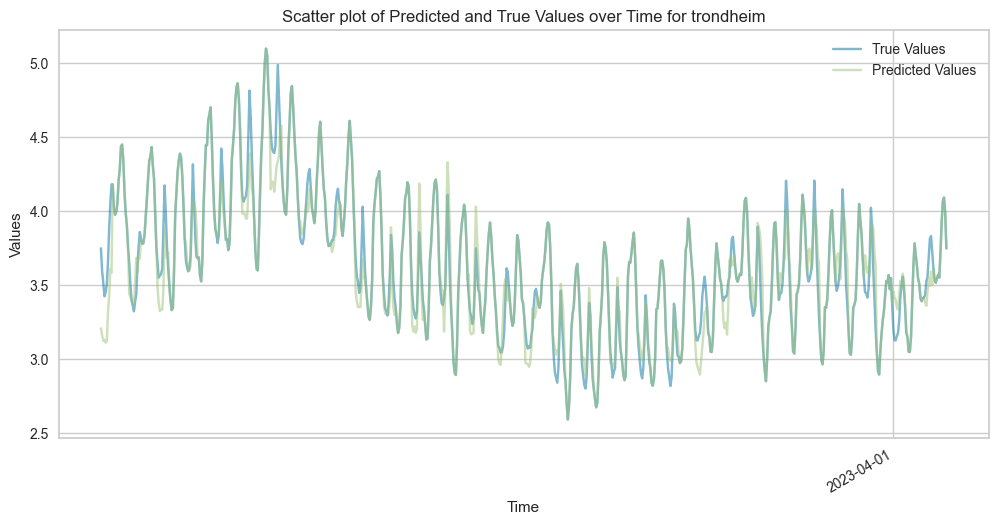

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

locations = combined_predictions['original_location'].unique()

for location in locations:
    plt.figure(figsize=(12, 6))
    
    subset_df = combined_predictions[combined_predictions['original_location'] == location]
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    
    plt.plot(time, true_values, alpha=0.5, label='True Values')
    plt.plot(time, predicted_values, alpha=0.5, label='Predicted Values')

    # Formatting the x-axis as date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval for readability if needed
    plt.gcf().autofmt_xdate()

    plt.title(f'Scatter plot of Predicted and True Values over Time for {location}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

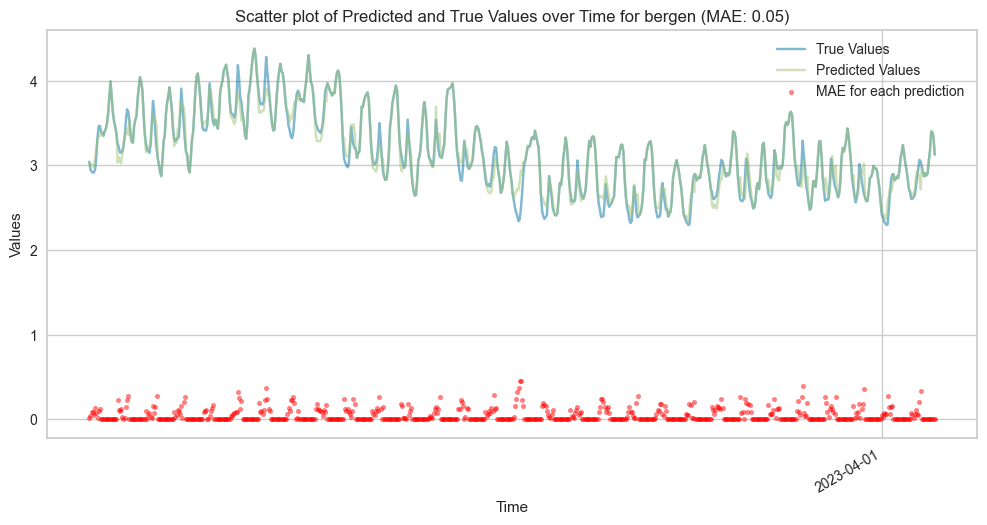

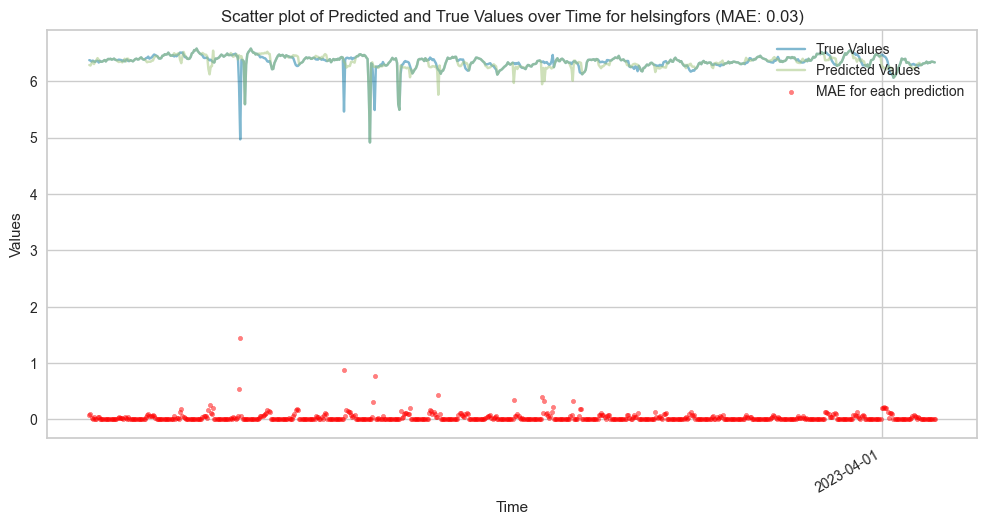

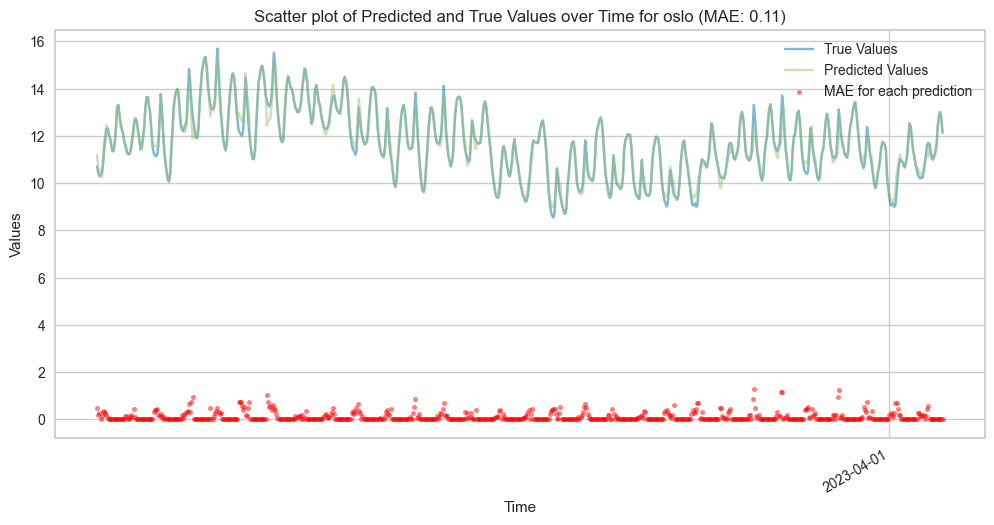

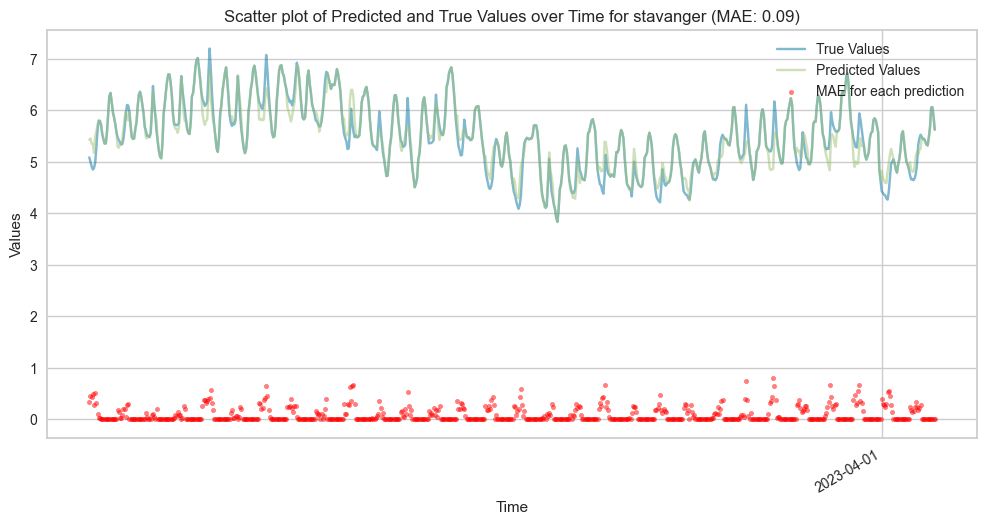

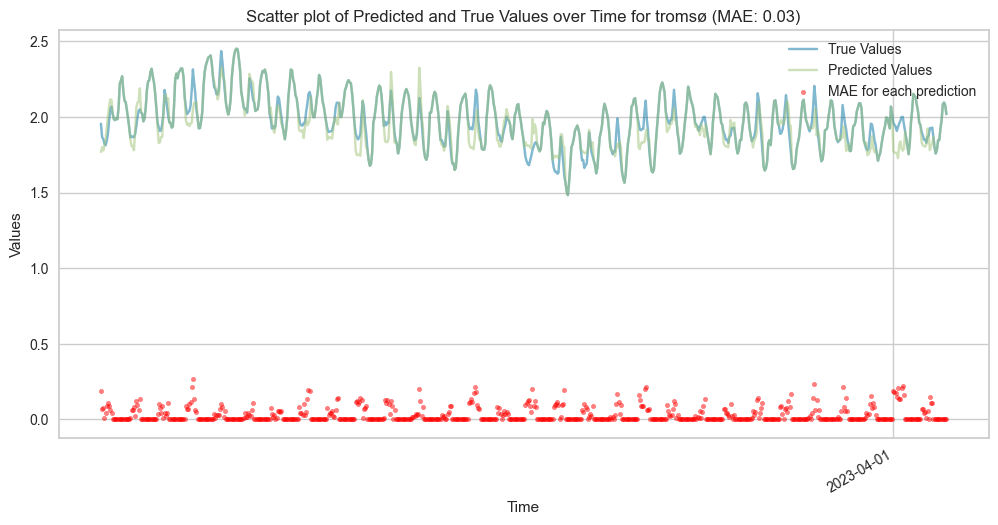

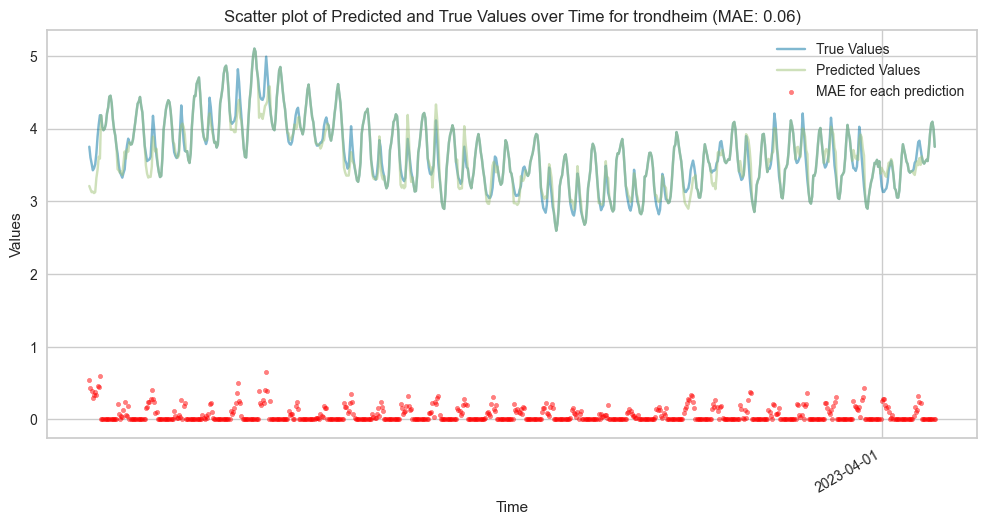

MAE for bergen: 0.05
MAE for helsingfors: 0.03
MAE for oslo: 0.11
MAE for stavanger: 0.09
MAE for tromsø: 0.03
MAE for trondheim: 0.06


In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error

locations = combined_predictions['original_location'].unique()
mae_per_location = {}  # Store MAE for each location

for location in locations:
    plt.figure(figsize=(12, 6))
    
    subset_df = combined_predictions[combined_predictions['original_location'] == location]
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    
    # Calculate MAE for the location
    mae = mean_absolute_error(true_values, predicted_values)
    mae_per_location[location] = mae
    
    # Plotting
    plt.plot(time, true_values, alpha=0.5, label='True Values')
    plt.plot(time, predicted_values, alpha=0.5, label='Predicted Values')
    
    # Scatter plot for MAE for each prediction
    errors = abs(true_values - predicted_values)
    plt.scatter(time, errors, color='red', label='MAE for each prediction', s=10, alpha=0.5)

    # Formatting the x-axis as date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval for readability if needed
    plt.gcf().autofmt_xdate()

    plt.title(f'Scatter plot of Predicted and True Values over Time for {location} (MAE: {mae:.2f})')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Print MAE for each location
for location, mae in mae_per_location.items():
    print(f"MAE for {location}: {mae:.2f}")


In [22]:
true_values = combined_predictions['consumption']
predicted_values = combined_predictions['prediction_label']
    
    # Calculate MAE for the location
mae = mean_absolute_error(true_values, predicted_values)

print(f"MAE: {mae:.2f}")

MAE: 0.06
